# Inventory Monitoring at Distribution Centers (Amazon Bin Image counting)

In this notebook, we orchestrate the developed units at the other scripts to create our machine learning pipeline.

We'll begin with gathering the dataset from Amazon s3 bucket into our file system, organize them into dataframes, apply an exploratory data analysis(EDA), and plot the various subsets of the data w.r.t the number of items they have in.

Then, we'll create our model, tune its hyperparameters, train it on the train split of the final dataset, and evaluate it on the dataset test split.

In the middle, we'll debug and profile the resource usage of our model, and give a report of our resource monitoring.

In [3]:
# TODO: Install any packages that you might need
!pip install smdebug -q -U
!pip install torchvision -q
!pip install timm -q


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
# TODO: Import any packages that you might need
import sagemaker
from sagemaker.tuner import (IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner)
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import (Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile)
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker.serializers import IdentitySerializer

from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts


import boto3

import os
import io
import json
import random
from tqdm import tqdm
import pandas as pd
import IPython
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-04-10 13:42:43.987 pytorch-1-12-gpu-py38-ml-t3-medium-5c243b1aae6a0c39c0e73a7744b4:67 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


/opt/conda/lib/python3.8/site-packages/smdebug-1.0.24b20230214-py3.8.egg/smdebug/profiler/system_metrics_reader.py:78: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/opt/conda/lib/python3.8/site-packages/smdebug-1.0.24b20230214-py3.8.egg/smdebug/profiler/system_metrics_reader.py:78: SyntaxWarning: "is not" with a literal. Did you mean "!="?


## Exploratory Data Analysis on Amazon Bin Image Dataset

### About data
There is a documentation for the dataset which can be accessed from [here](https://github.com/awslabs/open-data-docs/tree/main/docs/aft-vbi-pds).

### How to access?
The dataset can be downloaded from [here](https://registry.opendata.aws/amazon-bin-imagery/).

### Metadata
Metadata files are JSON files containing some information about the items in the dataset.

In [9]:
!aws s3 cp --no-sign-request s3://aft-vbi-pds/metadata/1.json -

{
    "BIN_FCSKU_DATA": {},
    "EXPECTED_QUANTITY": 0,
    "image_fname": "1.jpg"
}

For this task, we only work with ```image_fname``` and ```EXPECTED_QUANTITY``` fields of the metadata.

In [13]:
!aws s3 ls --no-sign-request s3://aft-vbi-pds/metadata/ --summarize > metadatalist

In [14]:
!tail metadatalist

2017-01-14 01:59:16       4529 99993.json
2017-01-14 01:59:16       4529 99994.json
2017-01-14 01:59:16       3740 99995.json
2017-01-14 01:59:16        864 99996.json
2017-01-14 01:59:16       2132 99997.json
2017-01-14 01:59:16       2770 99998.json
2017-01-14 01:59:16       1658 99999.json

Total Objects: 536435
   Total Size: 1098414519


The dataset contains 536,435 JSON metadata files.

### Data

In [11]:
!aws s3 ls --no-sign-request s3://aft-vbi-pds/bin-images/ --summarize > list

In [12]:
!tail list

2017-01-14 02:03:14      80192 99993.jpg
2017-01-14 02:03:14     104201 99994.jpg
2017-01-14 02:03:14     103665 99995.jpg
2017-01-14 02:03:14      58212 99996.jpg
2017-01-14 02:03:14      39300 99997.jpg
2017-01-14 02:03:14      36076 99998.jpg
2017-01-14 02:03:14      35218 99999.jpg

Total Objects: 536435
   Total Size: 30466377489


The dataset has 536,435 JPEG files in total in alignment with metadata files. Due to file naming rules, they can be divided into three categories:

- 1~4 digit: ```1.jpg``` ~ ```1200.jpg```: 1200
- 5-digit: ```00001.jpg``` ~ ```99999.jpg```: 99,999
- 6-digit: ```100000.jpg``` ~ ```535234.jpg```: 435,235

Furthermore, the capstone repository provides us with a chosen subset of the dataset, ```file_list.json```. We'll investigate that later.

#### 1. 1200 files with 1~4 digits in their file names(```1.jpg``` to ```1200.jpg```)

The cell below creates a folder called `metadata_1_1200`, downloads the metadata into this folder.

In [17]:
def download_metadata():
    s3_client = boto3.client('s3')

    local_directory = 'metadata_1_1200'
    s3_directory = 'metadata'
    if not os.path.exists(local_directory):
        os.makedirs(local_directory)
    for i in tqdm(range(1, 1201)):
        file_name = "%s.json" % i
        s3_client.download_file('aft-vbi-pds', os.path.join(s3_directory, file_name), os.path.join(local_directory, file_name))

In [18]:
download_metadata()

100%|██████████| 1200/1200 [01:34<00:00, 12.68it/s]


If we want to have and exploratory data analysis on this subset of the main dataset, we can organize it in a dataframe and get the statistics from it.

In [19]:
values = []
directory = "metadata_1_1200"
for i in range(1, 1201):
    filename = "%s/%s.json" % (directory, i)
    with open(filename, "r") as f:
        data = json.load(f)
        n = data['EXPECTED_QUANTITY']
        values.append(n)

df = pd.DataFrame({'quantity': values})

In [20]:
df.head()

,quantity
0,0
1,0
2,0
3,0
4,0


In [21]:
df.describe()

,quantity
count,1200.000000
mean,2.500000
std,1.708537
min,0.000000
25%,1.000000
50%,2.500000
75%,4.000000
max,5.000000


array([[<Axes: title={'center': 'quantity'}>]], dtype=object)

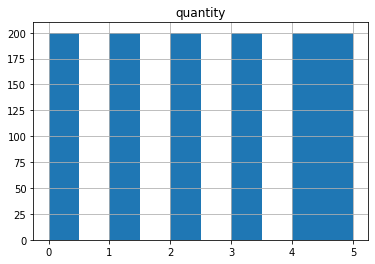

In [22]:
df.hist()

As we can see, Group 1 is distributed evenly and has no imbalance between different quantities.

#### 2. 99,999 files with 5 digits in their file names(00001.jpg to 99999.jpg)

We repeat the same procecss we applied on the ```Group 1``` for ```Group 2```.

In [23]:
def download_metadata():
    s3_client = boto3.client('s3')

    local_directory = 'metadata_00001_99999'
    s3_directory = 'metadata'
    if not os.path.exists(local_directory):
        os.makedirs(local_directory)
    for i in tqdm(range(1, 100000)):
        file_name = "%05d.json" % i
        s3_client.download_file('aft-vbi-pds', os.path.join(s3_directory, file_name), os.path.join(local_directory, file_name))

In [36]:
download_metadata()

100%|██████████| 99999/99999 [2:24:28<00:00, 11.54it/s]  


In [37]:
values = []
directory = "metadata_00001_99999"
for i in range(1, 100000):
    filename = "%s/%05d.json" % (directory, i)
    with open(filename, "r") as f:
        data = json.load(f)
        n = data['EXPECTED_QUANTITY']
        values.append(n)

df = pd.DataFrame({'quantity': values})

In [39]:
df.head()

,quantity
0,12
1,17
2,16
3,5
4,4


In [41]:
df.describe()

,quantity
count,99999.000000
mean,5.125321
std,4.758112
min,0.000000
25%,3.000000
50%,4.000000
75%,6.000000
max,209.000000


<Axes: >

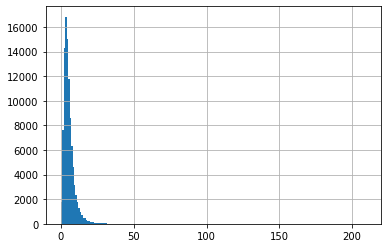

In [44]:
df['quantity'].hist(bins=210)

As we can see, ```Group 2``` had a skewed distribution and has an intense imbalance between different quantities.

#### 3. 10441 files in ```file_list.json```.

Now it's time to invetigate the ```file_list.json``` file as ```Group 3``` .

In [25]:
def  create_splits(data_dir):
    with open(data_dir, 'r') as f:
        d=json.load(f)

    train = {}
    valid = {}
    test = {}
    for k, v in d.items():
        l = len(v)
        print("%s has %d items" % (k, l))
        random.shuffle(v)
        i = (int)(0.8 * l)
        j = (int)(0.9 * l)
        train[k] = v[:i]
        valid[k] = v[i:j]
        test[k] = v[j:]
        print("%s:%s:%s" % (len(train[k]), len(valid[k]), len(test[k])))

    with open('train.json', 'w') as f:
        json.dump(train, f)
    with open('valid.json', 'w') as f:
        json.dump(valid, f)
    with open('test.json', 'w') as f:
        json.dump(test, f)

In [27]:
create_splits('file_list.json')

1 has 1228 items
982:123:123
2 has 2299 items
1839:230:230
3 has 2666 items
2132:267:267
4 has 2373 items
1898:237:238
5 has 1875 items
1500:187:188


In [28]:
def download_and_arrange_data(folder):
    s3_client = boto3.client('s3')

    with open(f"{folder}.json", 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join(folder, k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

In [29]:
download_and_arrange_data('train')
download_and_arrange_data('valid')
download_and_arrange_data('test')

100%|██████████| 982/982 [01:33<00:00, 10.47it/s]


100%|██████████| 1839/1839 [03:03<00:00, 10.02it/s]


100%|██████████| 2132/2132 [03:31<00:00, 10.09it/s]


100%|██████████| 1898/1898 [03:10<00:00,  9.99it/s]


100%|██████████| 1500/1500 [02:22<00:00, 10.54it/s]


100%|██████████| 123/123 [00:12<00:00, 10.07it/s]


100%|██████████| 230/230 [00:21<00:00, 10.55it/s]


100%|██████████| 267/267 [00:26<00:00, 10.12it/s]


100%|██████████| 237/237 [00:22<00:00, 10.46it/s]


100%|██████████| 187/187 [00:17<00:00, 10.88it/s]


100%|██████████| 123/123 [00:11<00:00, 10.74it/s]


100%|██████████| 230/230 [00:22<00:00, 10.15it/s]


100%|██████████| 267/267 [00:26<00:00, 10.14it/s]


100%|██████████| 238/238 [00:21<00:00, 10.87it/s]


100%|██████████| 188/188 [00:17<00:00, 10.53it/s]


In [30]:
!ls -al train valid test

test:
total 60
drwxr-xr-x 7 sagemaker-studio root  6144 Apr 10 14:28 .
drwxr-xr-x 9 sagemaker-studio root  6144 Apr 10 14:27 ..
drwxr-xr-x 2 sagemaker-studio root  6144 Apr 10 14:27 1
drwxr-xr-x 2 sagemaker-studio root 14336 Apr 10 14:27 2
drwxr-xr-x 2 sagemaker-studio root 14336 Apr 10 14:27 3
drwxr-xr-x 2 sagemaker-studio root 14336 Apr 10 14:28 4
drwxr-xr-x 2 sagemaker-studio root 14336 Apr 10 14:28 5

train:
total 284
drwxr-xr-x 7 sagemaker-studio root  6144 Apr 10 14:22 .
drwxr-xr-x 9 sagemaker-studio root  6144 Apr 10 14:27 ..
drwxr-xr-x 2 sagemaker-studio root 38912 Apr 10 14:13 1
drwxr-xr-x 2 sagemaker-studio root 71680 Apr 10 14:16 2
drwxr-xr-x 2 sagemaker-studio root 71680 Apr 10 14:19 3
drwxr-xr-x 2 sagemaker-studio root 71680 Apr 10 14:22 4
drwxr-xr-x 2 sagemaker-studio root 38912 Apr 10 14:25 5

valid:
total 60
drwxr-xr-x 7 sagemaker-studio root  6144 Apr 10 14:26 .
drwxr-xr-x 9 sagemaker-studio root  6144 Apr 10 14:27 ..
drwxr-xr-x 2 sagemaker-studio root  6144 Apr 10 14:

In [45]:
with open('file_list.json', 'r') as f:
    d = json.load(f)

quantities = []
file_names = []
for k, v in d.items():
    quantities.append([k] * len(v))
    file_names.append(v)
    print("%s has %d items" % (k, len(v)))

quantities = [item for sublist in quantities for item in sublist]
file_names = [item for sublist in file_names for item in sublist]

df = pd.DataFrame({"data": file_names, "quantity": quantities})

1 has 1228 items
2 has 2299 items
3 has 2666 items
4 has 2373 items
5 has 1875 items


In [50]:
df.head()

,data,quantity
0,data/metadata/100313.json,1
1,data/metadata/09915.json,1
2,data/metadata/103299.json,1
3,data/metadata/00710.json,1
4,data/metadata/05397.json,1


In [61]:
df["quantity"] = pd.to_numeric(df["quantity"])

In [64]:
df.describe()

,quantity
count,10441.000000
mean,3.131022
std,1.272490
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


<Axes: >

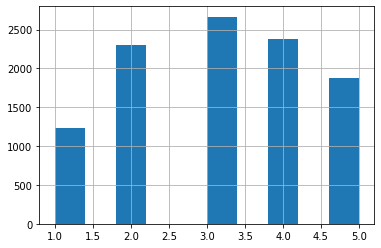

In [63]:
df["quantity"].hist()

As we can see, ```Group 3``` is somewhere in between ```Group 1``` and ```Group 2```.  It has a less skewed distribution than ```Group 2```  and has a bigger frequency than ```Group 1```. So these properties make ```file_list.json``` a good start point to train a model.

In [65]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

In [66]:
print(f"Default Bucket: {bucket}")
print(f"RoleArn: {role}")

Default Bucket: sagemaker-us-east-1-598348623909
RoleArn: arn:aws:iam::598348623909:role/service-role/AmazonSageMaker-ExecutionRole-20230331T224577


In [67]:
# This cell needs to be run at first time. from second time on, we didn't have to it and 
# it's enough  to run the next cell to get S3 bucket.
def upload_to_s3(local_dir, bucket, prefix):
    inputs = sagemaker_session.upload_data(path=local_dir,  bucket=bucket,  key_prefix=prefix)
    return inputs

prefix = "capstone_project"

In [54]:
train = upload_to_s3("train", bucket, prefix)
print(f"input spec (in this case, just an S3 path): {train}")

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-598348623909/capstone_project


In [55]:
valid = upload_to_s3("valid", bucket, prefix)
print(f"input spec (in this case, just an S3 path): {valid}")

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-598348623909/capstone_project


In [56]:
test = upload_to_s3("test", bucket, prefix)
print(f"input spec (in this case, just an S3 path): {test}")

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-598348623909/capstone_project


In [83]:
!aws s3 cp train s3://sagemaker-us-east-1-598348623909/capstone_project/train --recursive

upload: train/1/00084.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/train/1/00084.jpg
upload: train/1/00218.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/train/1/00218.jpg
upload: train/1/00194.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/train/1/00194.jpg
upload: train/1/00088.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/train/1/00088.jpg
upload: train/1/00024.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/train/1/00024.jpg
upload: train/1/00086.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/train/1/00086.jpg
upload: train/1/00148.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/train/1/00148.jpg
upload: train/1/00014.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/train/1/00014.jpg
upload: train/1/00100.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/train/1/00100.jpg
upload: train/1/00284.jpg to s3://sagemaker-us-east-1-598348623909/capstone_projec

In [84]:
!aws s3 cp valid s3://sagemaker-us-east-1-598348623909/capstone_project/valid --recursive

upload: valid/1/00289.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/valid/1/00289.jpg
upload: valid/1/00917.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/valid/1/00917.jpg
upload: valid/1/00048.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/valid/1/00048.jpg
upload: valid/1/01851.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/valid/1/01851.jpg
upload: valid/1/00214.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/valid/1/00214.jpg
upload: valid/1/00723.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/valid/1/00723.jpg
upload: valid/1/00525.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/valid/1/00525.jpg
upload: valid/1/00804.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/valid/1/00804.jpg
upload: valid/1/00634.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/valid/1/00634.jpg
upload: valid/1/00879.jpg to s3://sagemaker-us-east-1-598348623909/capstone_projec

In [85]:
!aws s3 cp test s3://sagemaker-us-east-1-598348623909/capstone_project/test --recursive

upload: test/1/01518.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/test/1/01518.jpg
upload: test/1/00312.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/test/1/00312.jpg
upload: test/1/00009.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/test/1/00009.jpg
upload: test/1/00918.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/test/1/00918.jpg
upload: test/1/00981.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/test/1/00981.jpg
upload: test/1/00316.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/test/1/00316.jpg
upload: test/1/01151.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/test/1/01151.jpg
upload: test/1/01976.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/test/1/01976.jpg
upload: test/1/01549.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/test/1/01549.jpg
upload: test/1/01357.jpg to s3://sagemaker-us-east-1-598348623909/capstone_project/test/1/01357.jpg


In [68]:
train = "s3://sagemaker-us-east-1-598348623909/capstone_project/train/"
valid = "s3://sagemaker-us-east-1-598348623909/capstone_project/valid/"
test = "s3://sagemaker-us-east-1-598348623909/capstone_project/test/"

Until now, we've prepared our data and stored it into S3 buckets. Now it's time to train a model.

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [85]:
hyperparameter_ranges = {
    "batch-size": CategoricalParameter([16, 64]),
    "epochs": IntegerParameter(4, 12),
}

In [86]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test Loss: ([+-]?[0-9\\.]+)"}]

In [103]:
estimator = PyTorch(
    entry_point="hpo_improved.py",
    role=role,
    py_version="py38",
    framework_version="1.12",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

In [104]:
tuner = HyperparameterTuner(
    estimator = estimator,
    early_stopping_type = "Auto",
    metric_definitions = metric_definitions,
    objective_metric_name = objective_metric_name,
    objective_type = objective_type,
    max_jobs = 4,
    max_parallel_jobs = 2,
    hyperparameter_ranges = hyperparameter_ranges
)

In [105]:
tuner.fit(
    {
        "training": train, 
        "valid": valid,
        "test": test,
    }, 
    wait=True
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-230410-2153


...................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [106]:
best_estimator = tuner.best_estimator()

best_estimator.hyperparameters()


2023-04-10 22:16:51 Starting - Preparing the instances for training
2023-04-10 22:16:51 Downloading - Downloading input data
2023-04-10 22:16:51 Training - Training image download completed. Training in progress.
2023-04-10 22:16:51 Uploading - Uploading generated training model
2023-04-10 22:16:51 Completed - Resource reused by training job: pytorch-training-230410-2153-004-7a998b9d


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"16"',
 'epochs': '11',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-04-10-21-53-19-610"',
 'sagemaker_program': '"hpo_improved.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-598348623909/pytorch-training-2023-04-10-21-53-19-610/source/sourcedir.tar.gz"'}

### Model Profiling and Debugging

While we are preparing to train and test the model, we are also in the process of preparing for debugging and profiling.

In [107]:
best_hyperparameters = {
    "batch-size": int(best_estimator.hyperparameters()["batch-size"].replace('"', "")),
    "epochs": best_estimator.hyperparameters()["epochs"],
}

In [108]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

### Training & Evaluation

We'll use multi-instance traiing to have a faster training process:

In [109]:
estimator = PyTorch(
    entry_point="train_improved.py",
    framework_version="1.12",
    py_version="py38",
    role=role,
    instance_count=2,
    instance_type="ml.g4dn.xlarge",
    hyperparameters=best_hyperparameters,
    rules=rules,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
)

In [110]:
estimator.fit(
    {
        "training": train, 
        "valid": valid,
        "test": test,
    }, 
    wait=True
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving i

2023-04-10 22:31:23 Starting - Starting the training job...
2023-04-10 22:31:52 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-04-10 22:32:53 Downloading - Downloading input data......
2023-04-10 22:33:53 Training - Downloading the training image............
2023-04-10 22:35:54 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-10 22:36:04,161 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-10 22:36:04,188 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-04-10 22:36:04,199 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-10 22:36:04,203 sagemaker_pytorch_contai

In [111]:
session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2023-04-10-22-31-22-950
Region: us-east-1


In [113]:
tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-598348623909/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-598348623909/pytorch-training-2023-04-10-22-31-22-950/profiler-output


Profiler data from system is available


We can now plot the debuggin output of our training process:

In [114]:
system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2023-04-10 22:57:29.201 pytorch-1-12-gpu-py38-ml-t3-medium-5c243b1aae6a0c39c0e73a7744b4:67 INFO metrics_reader_base.py:134] Getting 48 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-2', 'GPUUtilization-nodeid:algo-2', 'GPUMemoryUtilization-nodeid:algo-2', 'GPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1'}


For memory utilizations, we have an expected behavior since the training is going on GPU while we have evaluation phase on CPU. This increases data transfers between CPU and GPU. But because of budget limitation, we prefer to have these transfer instead of having an always on-GPU training and evalution.  

For CPU and GPU utilizations, we can see some oscilations for both. The utilization oscillations for CPU have higher peeks which can be originated from the computaion load of model evaluaion processes. It also shows that most of times, we are in training instead of evalution; In other words, the training has a bigger portion than evalution in the whole time. 

Since we have a multi-instance traiing with two instances, all of the paramters we mentioned above shuold be considered for both instances or nodes.

Now it's time to take a look at profiler.

In [115]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-598348623909/pytorch-training-2023-04-10-22-31-22-950/rule-output


In [116]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

2023-04-10 22:56:05     421725 pytorch-training-2023-04-10-22-31-22-950/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-04-10 22:56:04     279353 pytorch-training-2023-04-10-22-31-22-950/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-04-10 22:56:00        933 pytorch-training-2023-04-10-22-31-22-950/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-04-10 22:56:00      20276 pytorch-training-2023-04-10-22-31-22-950/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-04-10 22:56:00       2243 pytorch-training-2023-04-10-22-31-22-950/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-04-10 22:56:00        130 pytorch-training-2023-04-10-22-31-22-950/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-04-10 22:56:00       1009 pytorch-training-2023-04-10-22-31-22-950/rule-output/ProfilerReport/profiler-output/profiler-re

In [117]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [118]:
# TODO: Display the profiler output
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")